# A4 - Common Analysis  

During the last two years we all have been experiencing a global pandemic. This has been tragic and disruptive to many countries and has taken a deep personal toll on many individuals and their families.  
One aspect that has been hard to miss in the last two years is the datafication of the pandemic. That is, many aspects of the individual toll of the pandemic have been collected, aggregated and re-represented as data. This datafication gives us the privilege to examine the pandemic from potentially many different perspectives to understand how it has changed lives and how it has changed society. To be honest, we are actually at the very beginning of understanding and comprehending these impacts.  
During our Course Project we are going to begin taking a look at some of the social aspects of the pandemic by conducting a human centered data science analysis of some available COVID-19 data. In this Assignment A4: Common Analysis, every student in the course will work from the same datasets. Students will be assigned to analyze data for one specific County of the United States.

## Step 0 - Data Acquisition
The common analysis research question will require several different datasets. You will need:  
- The RAW_us_confirmed_cases.csv file from the [Kaggle repository of John Hopkins University COVID-19 data.](https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university?select=RAW_us_confirmed_cases.csv)  
- The [CDC dataset](https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i) of masking mandates by county.  
- The New York Times mask compliance [survey data.](https://github.com/nytimes/covid-19-data/tree/master/mask-use)  

The majority of this data is by US County by Day. The mask compliance is a single shot estimator that gives you a compliance estimate for every County in the US. You should carefully review the data descriptions that accompany these datasets. They each have some interesting caveats. As well, some of them are explicit with regard to the way you should interpret missing data.  

My assignment:  

| County | State | Area_km^2| Area_mi^2 | Population_2020_Census | Population_Increase_from_2010 | County Seat |  
| ------ | ----- | -------- | --------- | ---------------------- | ----------------------------- | ----------- |  
| Orange | California | 2,047.56 | 790.57 | 3,186,989 | 176,757 | Santa Ana |  

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
# Set up
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Show all columns
pd.set_option('display.max_columns', None)

# Set filepaths
RAW_DATA_PATH = '../data_raw/'
CLEAN_DATA_PATH = '../data_clean/'

# Set key dates
START_DATE = '2020-02-01'
END_DATE = '2021-10-15'

In [3]:
# Import data
cases_raw = pd.read_csv(RAW_DATA_PATH + 'RAW_us_confirmed_cases.csv/RAW_us_confirmed_cases.csv')
# Use the API from CDC and collect JUST the data from California
mandates_raw = pd.read_csv(RAW_DATA_PATH + 'U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')
masks_raw = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv')
print(cases_raw.head())
print(mandates_raw.head())
print(masks_raw.head())

  Province_State   Admin2       UID iso2 iso3  code3    FIPS Country_Region  \
0        Alabama  Autauga  84001001   US  USA    840  1001.0             US   
1        Alabama  Baldwin  84001003   US  USA    840  1003.0             US   
2        Alabama  Barbour  84001005   US  USA    840  1005.0             US   
3        Alabama     Bibb  84001007   US  USA    840  1007.0             US   
4        Alabama   Blount  84001009   US  USA    840  1009.0             US   

         Lat      Long_          Combined_Key  1/22/20  1/23/20  1/24/20  \
0  32.539527 -86.644082  Autauga, Alabama, US        0        0        0   
1  30.727750 -87.722071  Baldwin, Alabama, US        0        0        0   
2  31.868263 -85.387129  Barbour, Alabama, US        0        0        0   
3  32.996421 -87.125115     Bibb, Alabama, US        0        0        0   
4  33.982109 -86.567906   Blount, Alabama, US        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/

- FIPS is the key for each unique county. It is stored as 1 number in the `cases_raw` dataset but two values in the `mandate_raw` data set. When `FIPS_State` is single-digit then 0 is appended to the end before concatenating with `FIPS_County`. If `FIPS_County` is single digit as well, then 0 is appended to the beginning. Ex: Alabama Autauga County has state FIP 1 and county FIP 1, so it becomes 1001 for the combined FIP.
- For time-series analysis each date should be in one column, with the value in another. Long vs. wide data.  

In [4]:
# identify Orange County, CA FIPs code
fip = cases_raw.loc[(cases_raw['Province_State'] == 'California') & (cases_raw['Admin2'] == 'Orange'), 'FIPS'].values[0]
# print(fip)

# Create new combined FIPS column for mandates data set.
# If state code is single digit, then adds trailing 0
mandates = mandates_raw.copy()
mandates['FIPS'] = mandates['FIPS_County'] + mandates['FIPS_State'].apply(lambda x: x * 100 if x > 9 else x * 1000)
# Convert mandates_raw column into datetime
mandates['date'] = pd.to_datetime(mandates['date'], format = '%m/%d/%Y')

In [5]:
# Pivot case data to long format
cases = pd.melt(cases_raw, id_vars = cases_raw.columns[0:11], var_name = 'date', value_name = 'cases')
cases['date'] = pd.to_datetime(cases['date'], format = '%m/%d/%y')

In [6]:
print(cases.columns)
print(mandates.columns)
print(masks_raw.columns)

Index(['Province_State', 'Admin2', 'UID', 'iso2', 'iso3', 'code3', 'FIPS',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'date', 'cases'],
      dtype='object')
Index(['State_Tribe_Territory', 'County_Name', 'FIPS_State', 'FIPS_County',
       'date', 'order_code', 'Face_Masks_Required_in_Public',
       'Source_of_Action', 'URL', 'Citation', 'FIPS'],
      dtype='object')
Index(['COUNTYFP', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS'], dtype='object')


In [7]:
# Create combined data set and write to data_clean assuming we are in A4 folder
covid_df = cases.merge(mandates, how = 'left', on = ['FIPS', 'date'])\
    .merge(masks_raw, how = 'left', left_on = 'FIPS', right_on = 'COUNTYFP')\
    .drop(['iso2', 'iso3', 'code3', 'Country_Region', 'COUNTYFP'], axis = 1)

# covid_df.to_csv(CLEAN_DATA_PATH + 'us_covid-cases_mask-adoption_mandates.csv', index = False)

Orange County, CA Analysis
Some open questions here:
- What kind of mask use do we care about? In this case, I only consider whether or not masks were required in public spaces, or anywhere outside the individuals' home.  
- How long of a rolling average should we consider for daily cases, considering that the number of confirmed infections is affected by weekends and holidays? Here I use a 7-day rolling average
- How to define population at risk? With only the given information, we know the 2020 Census population estimate. We have access to the data set that contains the number of deaths, though that is not used here since the instructions specify not using outside information. In this case, the population at risk calculation does not include anyone who dies and is removed from the population. It also assumes that current infections are not considered at-risk, since they are already infected, and that they remain out of the population for 10 days. The reality is that this could be much longer or shorter depending on which variant is spreading, but for simplicity I will use 10 days.
- Assume that everyone wears a cloth mask, which is 67% effective at reducing transmission. 
$assumedcases = maskedcases / 0.67$

In [21]:
# Filter to just Orange County, CA, between 2020/02/01 and 2021/10/15
orange_df = covid_df.loc[(covid_df['FIPS'] == fip) &
                         (covid_df['date'] >= START_DATE) &
                         (covid_df['date'] <= END_DATE), ]\
    .rename({'Face_Masks_Required_in_Public': 'public_masks'}, axis = 1)\
    .sort_values(by = ['date'])

# Make public_masks boolean instead of 'Yes' and np.nan
orange_df['public_masks'] = orange_df['public_masks'] == 'Yes'
# Assume that everyone wears cloth masks which reduces spread by 67%.
# Mask-less COVID cases is masked cases / 0.67
MASK_EFFICACY = 0.67
# Daily case counts
orange_df['daily_cases'] = orange_df['cases'].diff(periods = 1)
orange_df['daily_cases_unmasked'] = np.where(orange_df['public_masks'],
                                             orange_df['daily_cases'] / MASK_EFFICACY,
                                             orange_df['daily_cases'])
# Rolling 7-day average
# Credit to Grant Savage for how to do this easily in Slack
orange_df['rolling_avg_cases'] = orange_df['daily_cases'].rolling(window = 7).mean()
orange_df['rolling_avg_cases_unmasked'] = orange_df['daily_cases_unmasked'].rolling(window = 7).mean()

# Add 2020 population from Census to calculate population-at-risk
orange_df['population'] = 3186989
# Assume that as soon as someone tests positive that they are infectious for the following 10 days
# and cannot get reinfected in that time
CONTAGIOUS_WINDOW = 10
orange_df['infectious_cases'] = orange_df['daily_cases'].rolling(window = CONTAGIOUS_WINDOW).sum().fillna(0)
orange_df['infectious_cases_unmasked'] = orange_df['daily_cases_unmasked'].rolling(window = CONTAGIOUS_WINDOW).sum().fillna(0)

# Calculate population-at-risk
# Population-at-risk = Population - infectious cases
orange_df['pop_at_risk'] = orange_df['population'] - orange_df['infectious_cases']
orange_df['pop_at_risk_unmasked'] = orange_df['population'] - orange_df['infectious_cases_unmasked']

# Calculate infection rate
# Infection rate = (number of daily infections) / (daily population at risk)
orange_df['infection_rate'] = 100.0 * orange_df['daily_cases'] / orange_df['pop_at_risk']
orange_df['infection_rate_unmasked'] = 100.0 * orange_df['daily_cases_unmasked'] / orange_df['pop_at_risk_unmasked']

# Calculate smoothed infection rate
# Smoothed rate = (7-day rolling average cases) / (daily population at risk)
orange_df['smooth_infection_rate'] = 100.0 * orange_df['rolling_avg_cases'] / orange_df['pop_at_risk']
orange_df['smooth_infection_rate_unmasked'] = 100.0 * orange_df['rolling_avg_cases_unmasked'] / orange_df['pop_at_risk_unmasked']

# Write to data_clean
orange_df.to_csv(CLEAN_DATA_PATH + 'orange-county_CA_covid-cases_mask-adoption_mandates.csv',
                 index = False)

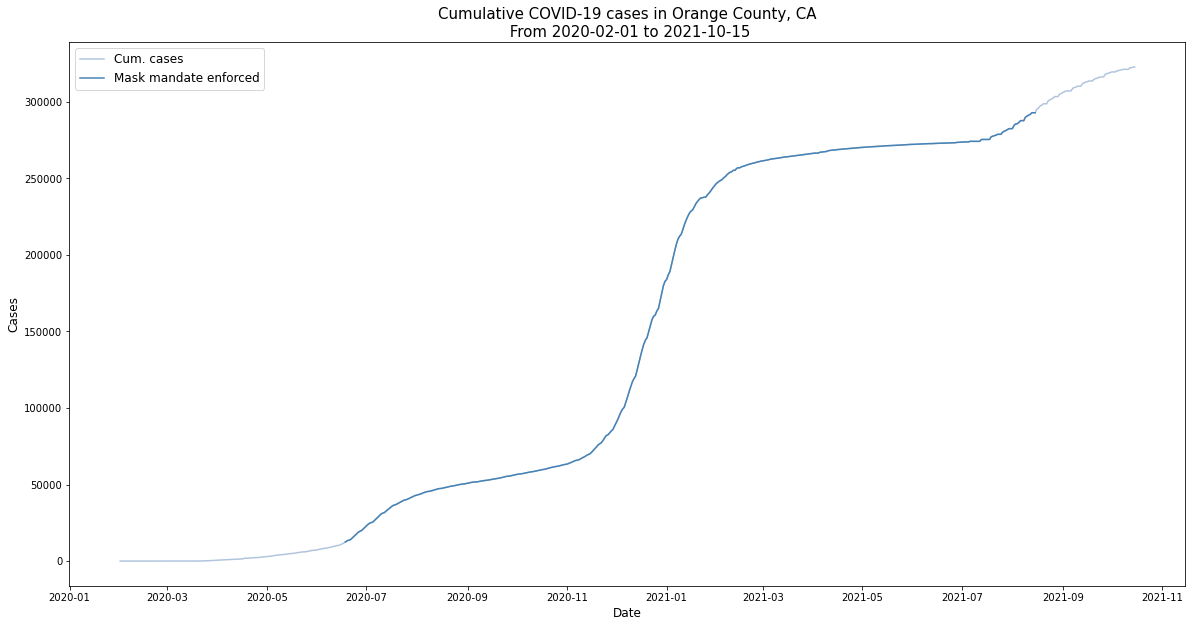

In [10]:
fig = plt.figure(figsize = (20, 10))
plt.plot(orange_df['date'], orange_df['cases'], label = 'Cum. cases', c = 'lightsteelblue')
plt.plot(orange_df.loc[orange_df['public_masks'], 'date'], orange_df.loc[orange_df['public_masks'], 'cases'], label = 'Mask mandate enforced', c = 'steelblue')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Cases', fontsize = 12)
plt.title('Cumulative COVID-19 cases in Orange County, CA\n From 2020-02-01 to 2021-10-15', fontsize = 15)
plt.legend(fontsize = 12)

Create a plot that shows the daily confirmed cases as a light blue bar, and daily confirmed cases while a mask mandate was being enforced as a darker blue bar. Add the 7-day rolling average of confirmed cases as an orange line over the bars.

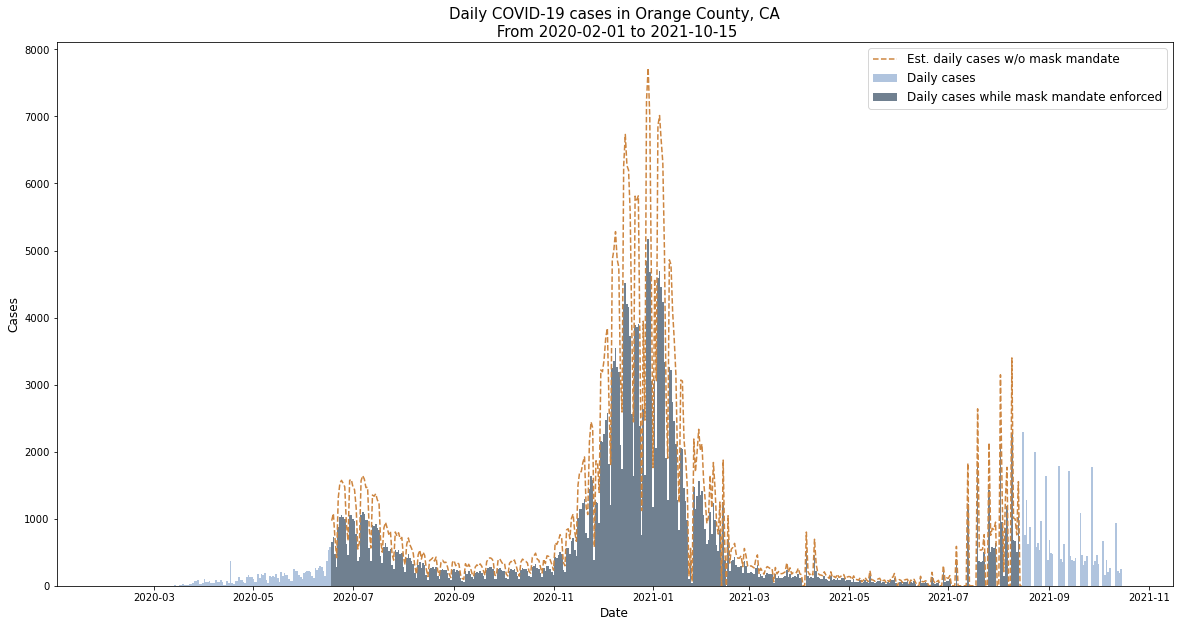

In [32]:
# Draw the plot
fig = plt.figure(figsize = (20, 10))
# First bar is plain case counts
plt.bar(orange_df['date'], orange_df['daily_cases'],
        label = 'Daily cases',
        color = 'lightsteelblue', width = 1)
# Second bar fills in case counts in a darker color when mask mandate is in place
plt.bar(orange_df.loc[orange_df['public_masks'], 'date'], orange_df.loc[orange_df['public_masks'], 'daily_cases'],
        label = 'Daily cases while mask mandate enforced',
        color = 'slategrey', width = 1)
# Line to follow 7-day daily case averages
plt.plot(orange_df.loc[orange_df['public_masks'], 'date'], orange_df.loc[orange_df['public_masks'], 'daily_cases_unmasked'],
         label = 'Est. daily cases w/o mask mandate enforced',
         color = 'peru', linestyle = '--')

# Formatting
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Cases', fontsize = 12)
plt.title('Daily COVID-19 cases in Orange County, CA\n From 2020-02-01 to 2021-10-15', fontsize = 15)
plt.legend(fontsize = 12)

# Save figure into the results folder
plt.savefig('../results/orange-county_CA_daily-cases.jpg')

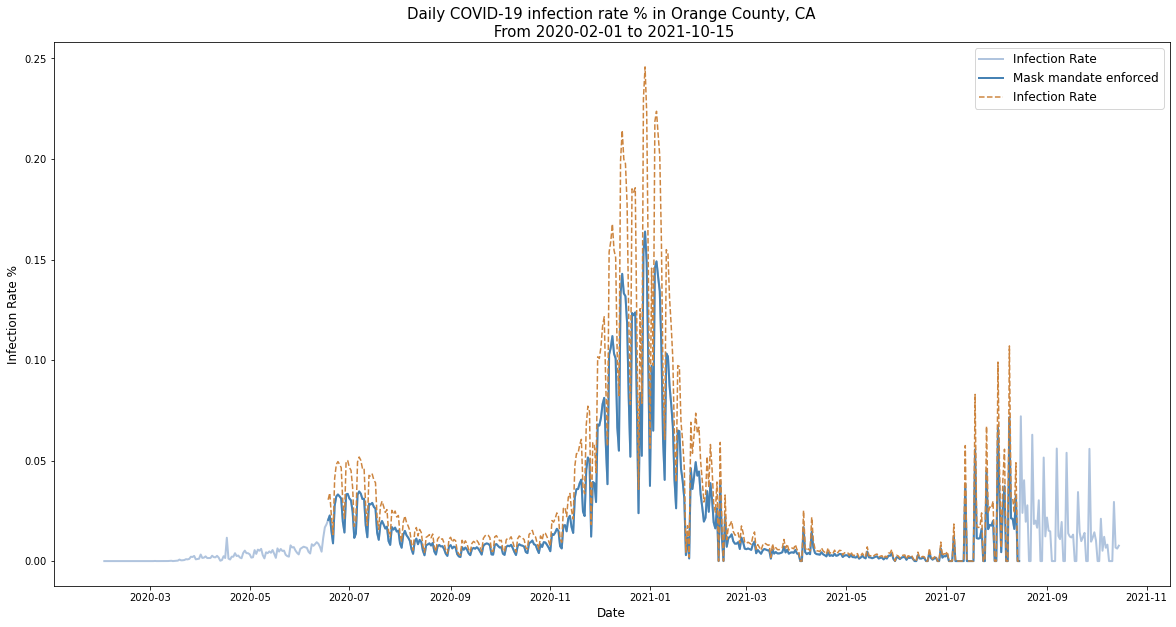

In [34]:
# Draw the plot
fig = plt.figure(figsize = (20, 10))
# Line to follow 7-day daily case averages
plt.plot(orange_df['date'], orange_df['infection_rate'],
         label = 'Infection Rate',
         color = 'lightsteelblue', linewidth = 2)
plt.plot(orange_df.loc[orange_df['public_masks'], 'date'], orange_df.loc[orange_df['public_masks'], 'infection_rate'],
         label = 'Mask mandate enforced',
         color = 'steelblue', linewidth = 2)
plt.plot(orange_df.loc[orange_df['public_masks'], 'date'], orange_df.loc[orange_df['public_masks'], 'infection_rate_unmasked'],
         label = 'Infection Rate',
         color = 'peru', linestyle = '--')
# Formatting
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Infection Rate %', fontsize = 12)
plt.title('Daily COVID-19 infection rate % in Orange County, CA\n From 2020-02-01 to 2021-10-15', fontsize = 15)
plt.legend(fontsize = 12)

# Save figure into the results folder
plt.savefig('../results/orange-county_CA_daily-infection-rate.jpg')

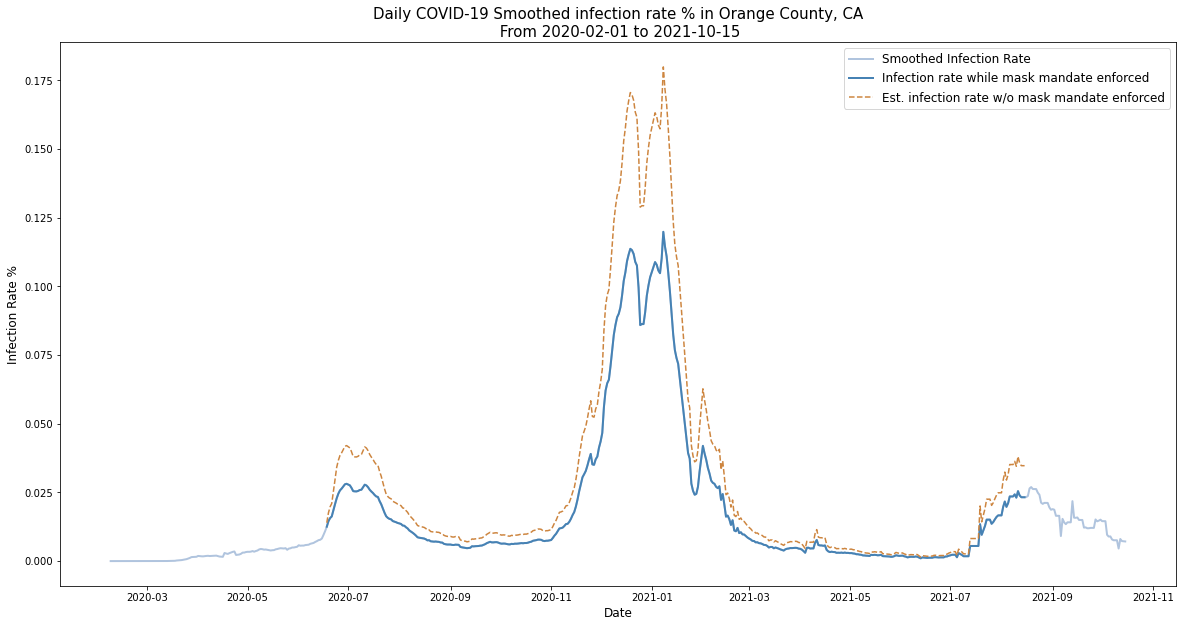

In [36]:
# Draw the plot
fig = plt.figure(figsize = (20, 10))
# Line to follow 7-day daily case averages
plt.plot(orange_df['date'], orange_df['smooth_infection_rate'],
         label = 'Smoothed Infection Rate',
         color = 'lightsteelblue', linewidth = 2)
plt.plot(orange_df.loc[orange_df['public_masks'], 'date'], orange_df.loc[orange_df['public_masks'], 'smooth_infection_rate'],
         label = 'Infection rate while mask mandate enforced',
         color = 'steelblue', linewidth = 2)
plt.plot(orange_df.loc[orange_df['public_masks'], 'date'], orange_df.loc[orange_df['public_masks'], 'smooth_infection_rate_unmasked'],
         label = 'Est. infection rate w/o mask mandate enforced',
         color = 'peru', linestyle = '--')
# Formatting
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Infection Rate %', fontsize = 12)
plt.title('Daily COVID-19 Smoothed infection rate % in Orange County, CA\n From 2020-02-01 to 2021-10-15', fontsize = 15)
plt.legend(fontsize = 12)

# Save figure into the results folder
plt.savefig('../results/orange-county_CA_daily-infection-rate-smoothed.jpg')

In [14]:
masks = masks_raw.copy()
masks['frequently_always'] = masks['FREQUENTLY'] + masks['ALWAYS']
masks.loc[masks['COUNTYFP'] == fip,'frequently_always']

215    0.91
Name: frequently_always, dtype: float64